# Double Deep Q-Learning with Dueling
---
This is the report for Project 1: Navigation of Udacity's Deep Reinforcement Learning Nanodegree.
### 1. Import the packages 

In [1]:
import torch
import numpy as np
from collections import deque
from unityagents import UnityEnvironment
from dqn_agent import Agent

import matplotlib.pyplot as plt
%matplotlib inline

### 2. Instantiate the environment 

In [2]:
env = UnityEnvironment(file_name="Banana_Linux/Banana.x86_64")
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### 3. Examine the environment 

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:\n', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like:
 [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 4. Build a neural network model (with dueling) to estimate Q-value function 
Feed forward fully-connected model with value and advantage streams that maps a given state to all possible actions for that state.

In [4]:
""" The model has 1 x input layer which receives the state parameters followed by 2 x hidden layers (64 units).
    It then splits into 2 streams, one to estimate the Value function of the state, and the other to estimate
    the relative advantage function for each possible action given that state. To obtain the Q-value function 
    for each possible action, V and A are aggregated into their sum which is then divided by the mean of A.
"""
from model import QNetwork
qnet = QNetwork(state_size, action_size, seed=0, num_layers=2, hidden_units=64, duel=True)
print(qnet)

QNetwork(
  (input): Linear(in_features=37, out_features=64, bias=True)
  (layers): ModuleList(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=64, bias=True)
  )
  (val_fc_input): Linear(in_features=64, out_features=32, bias=True)
  (val_fc_output): Linear(in_features=32, out_features=1, bias=True)
  (adv_fc_input): Linear(in_features=64, out_features=32, bias=True)
  (adv_fc_output): Linear(in_features=32, out_features=4, bias=True)
)


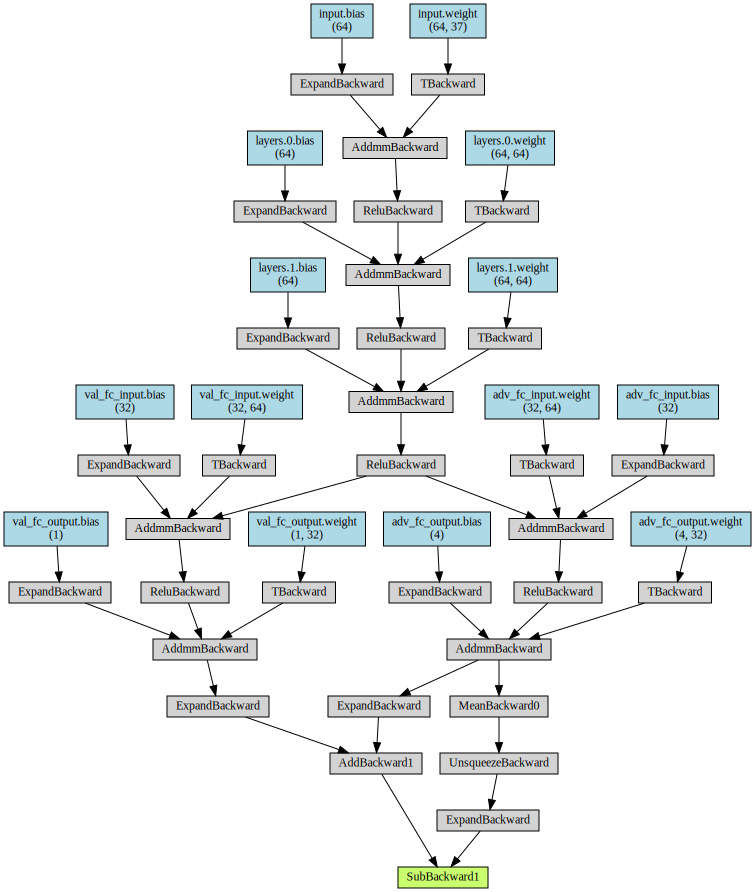

In [5]:
from torchviz import make_dot
make_dot(qnet(torch.from_numpy(np.expand_dims(state, axis=0)).float()), params=dict(qnet.named_parameters()))

### 5. Double DQN with Experience Replay 

Episode 100	Average Score: 0.47
Episode 200	Average Score: 3.64
Episode 300	Average Score: 6.70
Episode 400	Average Score: 11.16

Environment solved in 356 episodes!	Average Score: 13.01


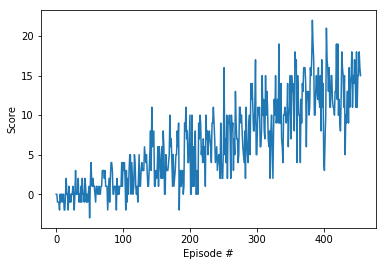

In [6]:
""" Double DQN is implemented in the Agent with the following two neural networks (identical architecture):
    - Local network (implements the agent's current policy)
    - Target network (estimates the Q-value function targets from which the agent learns)

    Experience replay is implemented through the Replay Buffer class, which stores and shuffles a batch of experiences for 
    the agent to learn from.
    
    Hyperparameters
    ---------------
    BUFFER_SIZE = int(1e5)  # replay buffer size
    BATCH_SIZE = 64         # minibatch size
    GAMMA = 0.99            # discount factor
    TAU = 1e-3              # for soft update of target parameters
    LR = 5e-4               # learning rate 
    UPDATE_EVERY = 4        # how often to update the network
    
    Action-selection is done using the Epsilon-greedy algorithm, with epsilon starting at 1.0 and decaying exponentially
    at a rate of 0.995 per episode until epsilon is 0.01.
"""

def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    
    scores = []
    scores_window = deque(maxlen=100)
    eps = eps_start
    
    # agent uses double DQN with dueling + experience replay
    agent = Agent(state_size=state_size, action_size=action_size, seed=0, num_layers=2, hidden_units=64)
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0]            # get the current state
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)                 # select an action (eps-greedy)
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            agent.step(
                state, action, reward, next_state, done)   # 
            score += reward                                # update the score
            state = next_state                             # roll over the state to next time step
            if done:
                break
        scores_window.append(score)
        scores.append(score)
        eps = max(eps_end, eps*eps_decay)

        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

scores = dqn()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [7]:
env.close()

### Future work 
Having implemented double DQN with dueling and experience replay, one possible improvement is to implement prioritized experience replay (PER).

It would also be interesting to explore the hyperparameters to investigate which ones have the biggest impact on agent learning. In the present case, some of the hyperparameters that may be more easily experimented with are the more orthogonal ones:
* epsilon-decay
* the NN model size
* experience-replay buffer size?

The other hyperparameters might be more challenging to experiment with as they may be interlinked with one another.